In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
import numpy as np
import seaborn as sns
import scipy as sp
from statsmodels.nonparametric.smoothers_lowess import lowess as sm_lowess

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, dpi_save=600,facecolor='white')

scanpy==1.10.4 anndata==0.11.1 umap==0.5.7 numpy==1.26.4 scipy==1.14.1 pandas==1.5.3 scikit-learn==1.5.2 statsmodels==0.14.4 pynndescent==0.5.13


In [3]:
adata = sc.read_h5ad('/storeData/USER/data/02.Bioinformatics_for_STOmics/01.user/qiuying/05.SDAS/00.data/01.paper_data/CRC_NC/sdas_rerun/output/RCTD_CPU_v1.0/stereo_bin100_standard_anno_rctd.h5ad')

### 计算每个bin与boundary的距离

In [4]:
def compute_min_distance(group):
    boundary = group[group['level2']=='boundary'][['x', 'y']].values
    if len(boundary) == 0:
        group['distances2'] = np.nan
        return group
    all_points = group[['x', 'y']].values

    diff = all_points[:, np.newaxis, :] - boundary[np.newaxis, :, :]
    distances = np.sqrt((diff**2).sum(axis=2))

    min_distances = distances.min(axis=1)
    group['distances2'] = min_distances
    return group

In [5]:
adata.obs = adata.obs.groupby('id', group_keys=False).apply(compute_min_distance)

In [6]:
mask = adata.obs['level2'].str.contains('epi_', na=False)
adata.obs['boundary_distance2'] = np.where(mask, adata.obs['distances2'], -adata.obs['distances2'])

In [7]:
all(adata.obs['boundary_distance2']==adata.obs['boundary_distance'])

True

### Fig.1c

In [8]:
newgroup = {
    'CRCP24_T': 'dCR',
    'CRCP25_T': 'dCR',
    'CRCP61_T': 'dCR',
    'CRCP95_T': 'dSD',
    'CRCP104_T': 'dSD',
    'CRCP112_T': 'dPR',
    'CRCP59_T_2': 'pMMR',
    'CRCP56_T':'dMMR',
    'CRCP67_T': 'pMMR',
    'CRCP59_T': 'pMMR',
    'CRCP50_T': 'pMMR',
    'CRCP107_T': 'dMMR',
    'CRCP71_T': 'pMMR',
    'CRCP99_T': 'dMMR',
    'CRCP100_T': 'dMMR',
}

/tmp/ipykernel_59969/1047639051.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=mk, x='group', y='percent',palette='viridis',order=['pMMR','dMMR','dSD','dPR','dCR'])


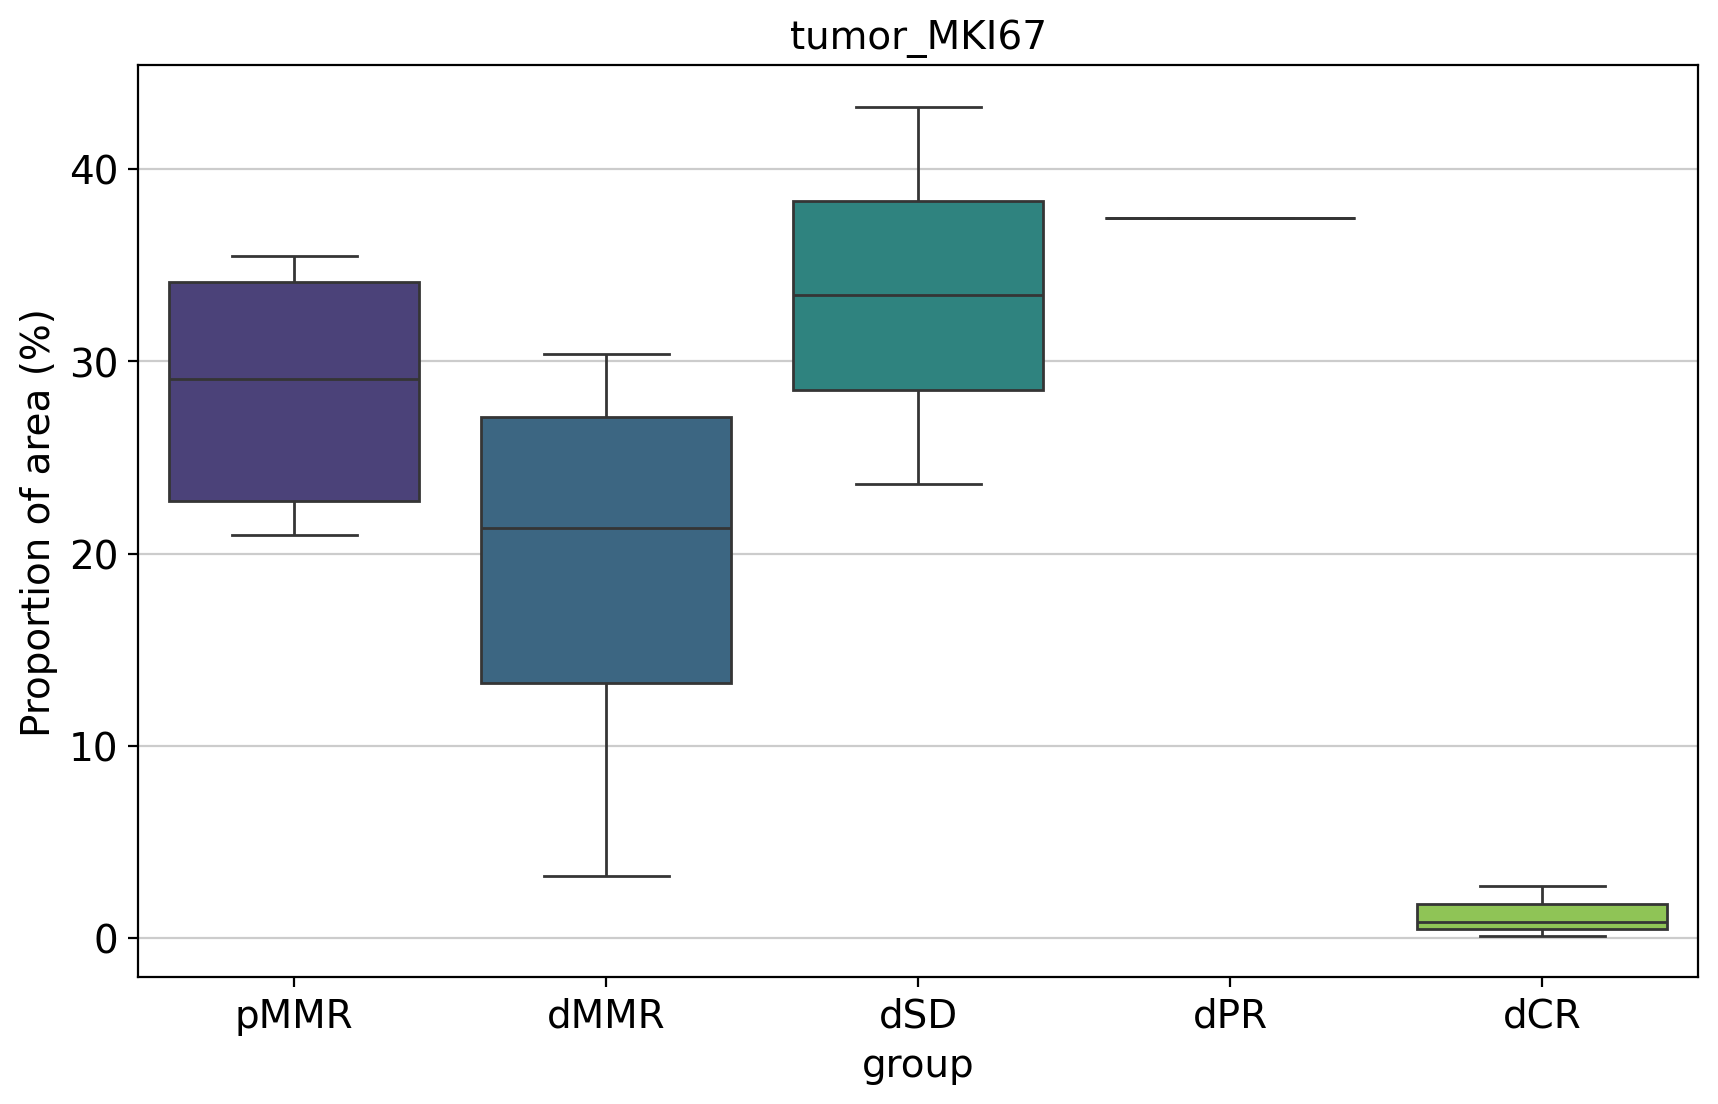

In [9]:
cell_counts = adata.obs.groupby(['id', 'level2']).size().unstack(fill_value=0)
cell_counts
cell_proportions = cell_counts.div(cell_counts.sum(axis=1), axis=0)
cell_proportions.rename_axis(None,inplace=True)
mk=pd.DataFrame(cell_proportions["epi_MKI67"])
mk.reset_index(inplace=True)
mk["group"]=mk["index"].map(newgroup)
mk["percent"]=mk["epi_MKI67"]*100
plt.figure(figsize=(10, 6))
sns.boxplot(data=mk, x='group', y='percent',palette='viridis',order=['pMMR','dMMR','dSD','dPR','dCR'])
plt.title('tumor_MKI67')
#plt.xlabel('Sample')
plt.ylabel('Proportion of area (%)')
#plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/tmp/ipykernel_59969/2358147353.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=mk, x='group', y='percent',palette='viridis',order=['pMMR','dMMR','dSD','dPR','dCR'])


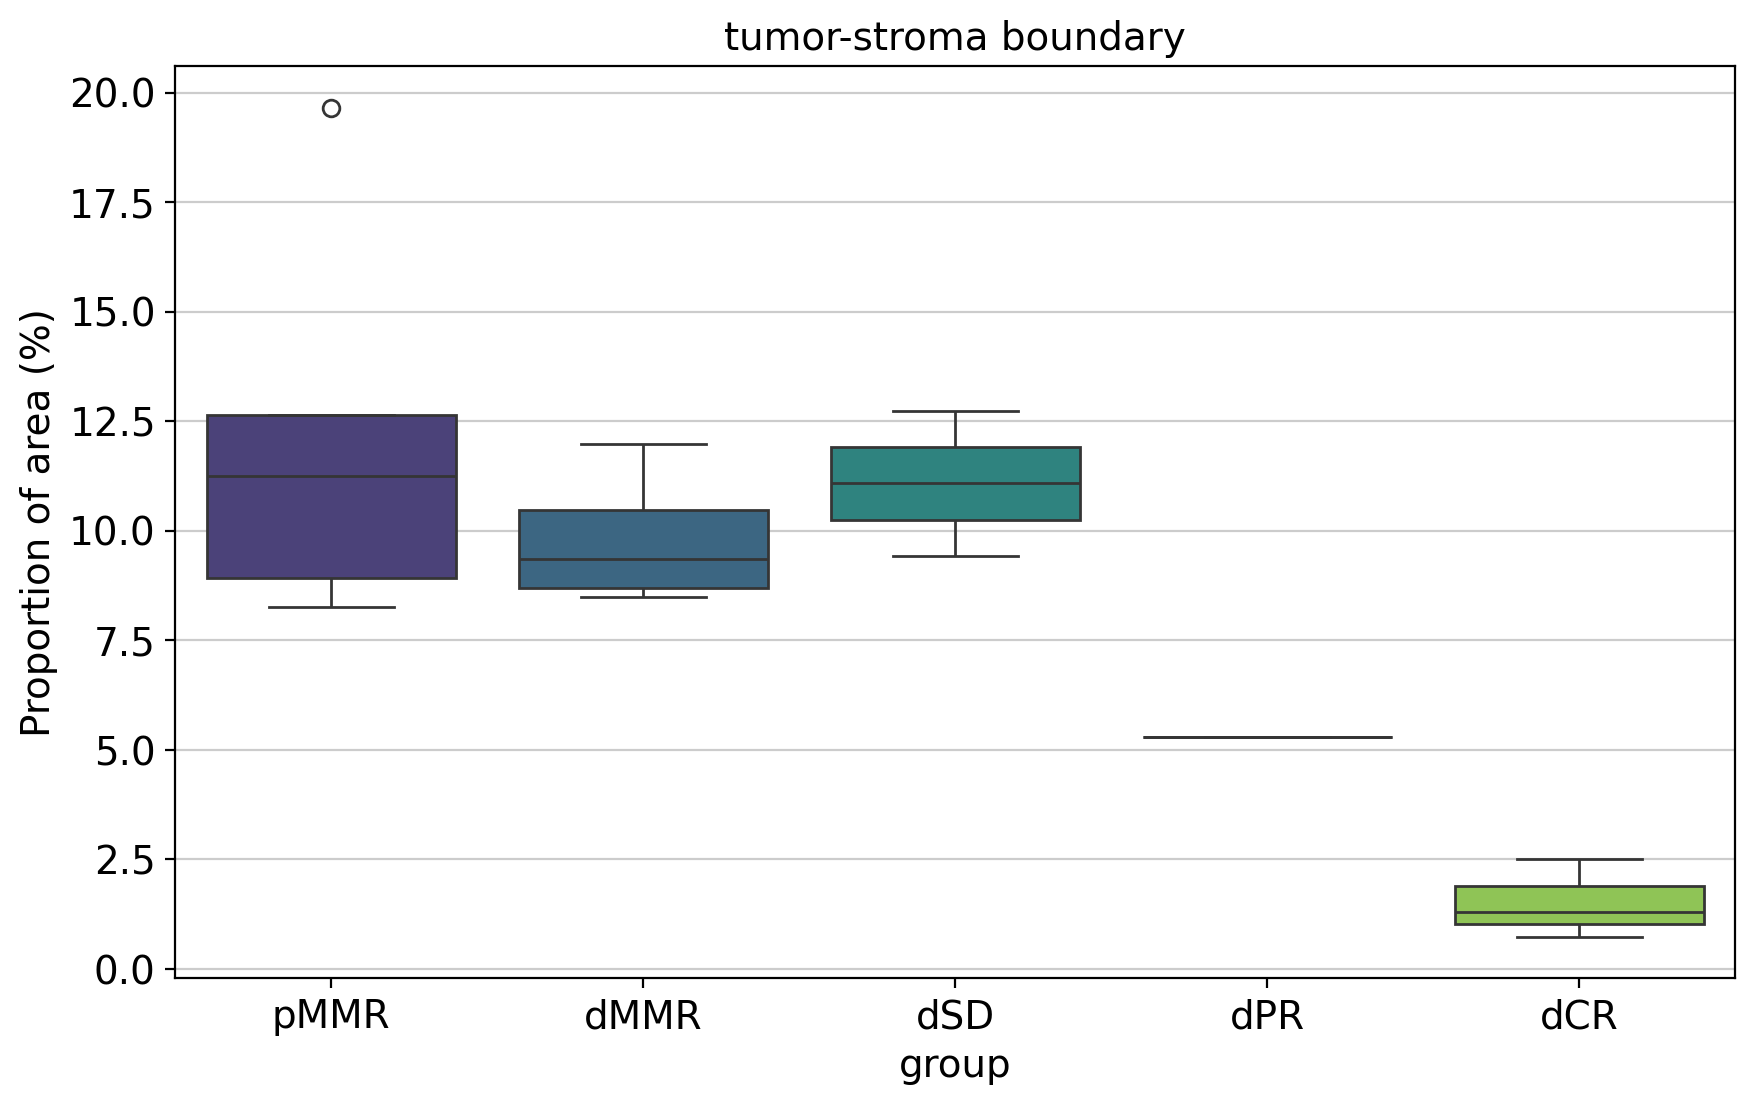

In [10]:
cell_counts = adata.obs.groupby(['id', 'level1']).size().unstack(fill_value=0)
cell_counts
cell_proportions = cell_counts.div(cell_counts.sum(axis=1), axis=0)
cell_proportions.rename_axis(None,inplace=True)
mk=pd.DataFrame(cell_proportions["boundary"])
mk.reset_index(inplace=True)
mk["group"]=mk["index"].map(newgroup)
mk["percent"]=mk["boundary"]*100
plt.figure(figsize=(10, 6))
sns.boxplot(data=mk, x='group', y='percent',palette='viridis',order=['pMMR','dMMR','dSD','dPR','dCR'])
plt.title('tumor-stroma boundary')
#plt.xlabel('Sample')
plt.ylabel('Proportion of area (%)')
#plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Fig2d_stackplot

In [11]:
adata.obs['group2'] = adata.obs['group2'].replace({'dNR':'dSD', 'dR':'dPR/dCR'})

In [12]:
annotation2_colors = ['#3182bdff', '#6baed6ff', '#a55194ff', '#ce6dbdff', '#de9ed6ff',
       '#e6550dff', '#ad494aff', '#e7969cff', '#843c39ff', '#7b4173ff',
       '#d6616bff', '#bd9e39ff', '#000000ff', '#756bb1ff', '#dadaebff',
       '#393b79ff', '#bcbddcff', '#5254a3ff', '#9c9edeff', '#6b6ecfff',
       '#9e9ac8ff', '#cedb9cff', '#31a354ff', '#74c476ff', '#8c6d31ff',
       '#c7e9c0ff', '#a1d99bff', '#fd8d3cff', '#c6dbefff', '#9ecae1ff',
       '#637939ff', '#8ca252ff', '#b5cf6bff']
categories = ['B_act', 'B_naive', 'CD4_CXCL13', 'CD4_Tcm', 'CD4_Treg', 'CD4_act', 
 'CD8_Cyto', 'CD8_HSP', 'CD8_Teff', 'CD8_Tem', 'CD8_Tex', 'Endo', 
 'Epi', 'Fibro_ADAMDEC1', 'Fibro_CXCL8', 'Fibro_CXCL14', 'Fibro_GPM6B', 
 'Fibro_KCNN3', 'Fibro_MYH11', 'Fibro_NOTCH3', 'Fibro_PI16', 'Mac_M1', 
 'Mac_M2', 'Mac_SPP1', 'Mast', 'Monocyte_IDO1', 'Monocyte_S100A8', 'NK_gdT', 
 'Plasma_IgG', 'Plasma_IgM', 'cDC1', 'cDC2', 'pDC']

/tmp/ipykernel_59969/3060243736.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distance['boundary_int_um']=distance['boundary_distance'].round() * 50
/tmp/ipykernel_59969/3060243736.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merge = distance.drop(columns=['boundary_distance']).groupby(['boundary_int_um']).mean().reset_index()
/tmp/ipykernel_59969/3060243736.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

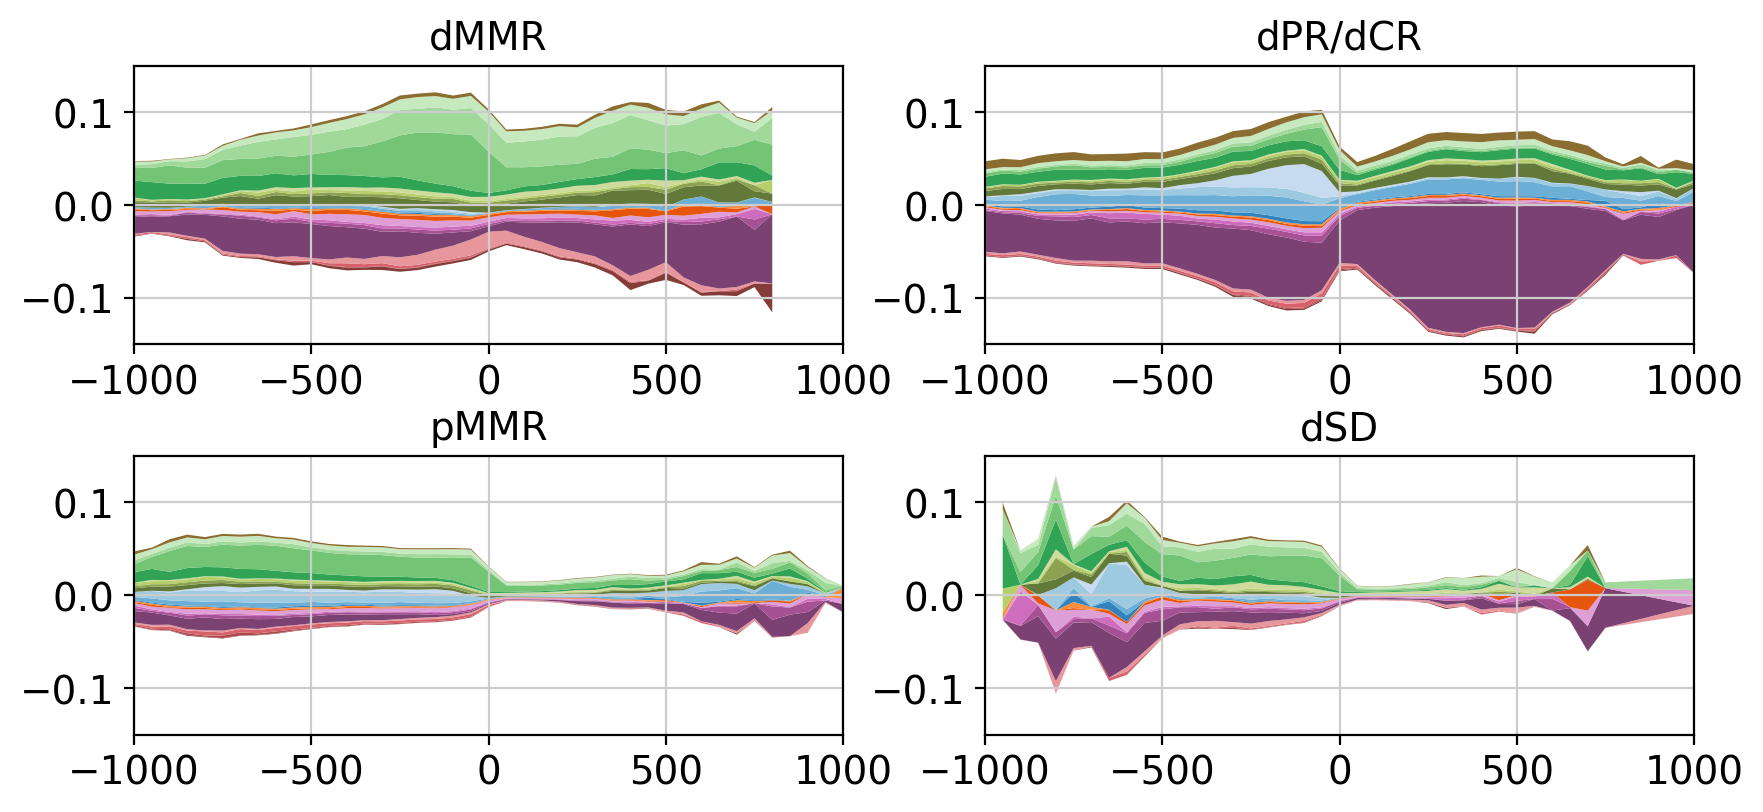

In [13]:
distances = pd.concat([adata.obs.copy(), adata.obsm['anno_score_rctd']], axis=1)
distances = distances.sort_values('boundary_distance')

#add group info and subset to d/pMMR
celltypes = ['CD8_Teff','CD8_Cyto','CD8_CXCL13','CD8_HSP','CD8_Tem','CD4_CXCL13','CD4_Tcm','CD4_Treg','CD4_act','NK_gdT',
             'B_act','B_naive','Plasma_IgM','Plasma_IgG',
             'cDC1','cDC2','pDC','Mac_M1','Mac_M2','Mac_SPP1','Monocyte_S100A8','DC_LAMP3','Mast']
#            'Endo', 'Fibro_ADAMDEC1', 'Fibro_CXCL8', 'Fibro_CXCL14', 'Fibro_GPM6B', 'Fibro_KCNN3', 'Fibro_MYH11', 'Fibro_NOTCH3', 'Fibro_PI16']
#读取颜色
table=pd.DataFrame(annotation2_colors, categories,columns=['col']).T
table=table.rename(columns={'CD8_Tex':'CD8_CXCL13', 'Monocyte_IDO1':'DC_LAMP3'})
table=table[celltypes].T

distances['type'] = adata.obs['group2'][distances.index]
#set range
r=20 * 50

x=len(adata.obs['group2'].unique().to_list())
# tmp=adata.obs['group2'].unique().to_list()
tmp = ['dMMR', 'dPR/dCR', 'pMMR', 'dSD']

matplotlib.rcParams['figure.figsize'] = (10, 4.4)
plt.subplots_adjust(hspace=0.4)
for a in range(x):
    i=tmp[a]
    distance= distances
    distance = distance[distance['type']==i]
    distance['boundary_int_um']=distance['boundary_distance'].round() * 50
    # distance['boundary_int_um']=0-distance['boundary_int_um']

    merge = distance.drop(columns=['boundary_distance']).groupby(['boundary_int_um']).mean().reset_index()
    merge = merge[np.abs(merge['boundary_int_um'])<=r]

    merge=merge[['boundary_int_um']+celltypes]
    #merge = merge[~merge['B_act'].isna()]
    smoothed = merge.interpolate(method='slinear').set_index('boundary_int_um')        
    # Plot a stackplot - https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/stackplot_demo.html
    # with plt.rc_context({'figure.figsize': [5, 2]}):
    #     plt.stackplot(smoothed.index, smoothed.T,baseline='wiggle', labels=smoothed.columns,colors=table['col']) #basline: 'zero', 'sym', 'wiggle', 'weighted_wiggle'
    plt.subplot(2,2,a+1)
    plt.stackplot(smoothed.index, smoothed.T,baseline='wiggle', labels=smoothed.columns,colors=table['col']) #basline: 'zero', 'sym', 'wiggle', 'weighted_wiggle'    
    # Move the legend off of the chart
#    plt.legend(loc=(1.04,0))
    plt.ylim(-0.15,0.15)
    plt.xlim(-1000,1000)
    # Set the title
    plt.title(i)
    # plt.savefig('./fig2d_stackplot_'+i.replace('/','_')+'.pdf',bbox_inches = 'tight')
    # plt.show()
plt.savefig('./fig2d_stackplot'+'.pdf',bbox_inches = 'tight')    

### Fig. 2f immune_cell_rctd_distance

In [14]:
def loess_smooth(data,column,type):
    x=data[data['type']==type]['boundary_distance']
    y=data[data['type']==type][column]
    sm_x, sm_y = sm_lowess(y, x,  frac=0.15, 
                           it=2, return_sorted = True).T
    return(sm_x,sm_y)

/tmp/ipykernel_59969/3793904122.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merge = distance.groupby(['type','boundary_distance']).mean().reset_index()


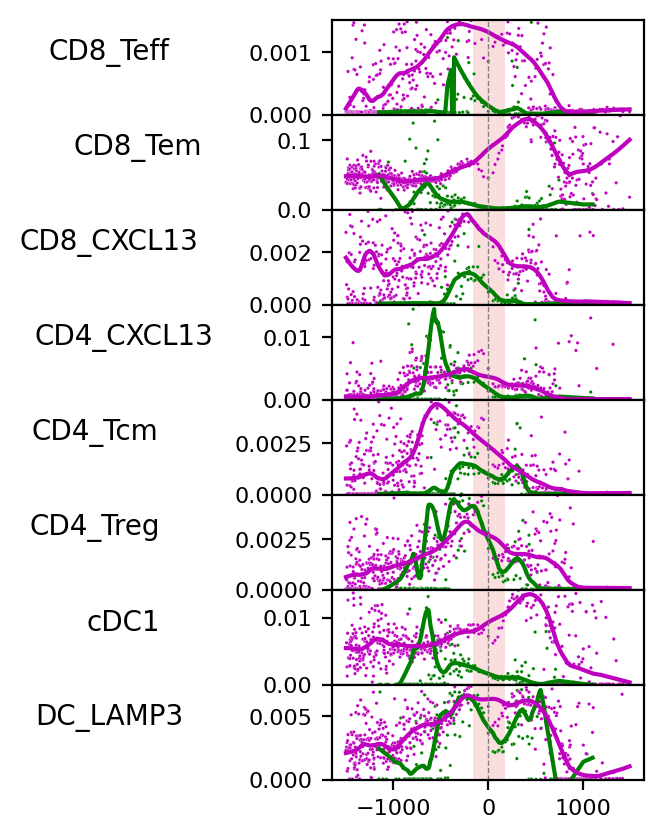

In [15]:
celltypes=['CD8_Teff','CD8_Tem','CD8_CXCL13','CD4_CXCL13','CD4_Tcm','CD4_Treg','cDC1','DC_LAMP3']
#order=['pMMR', 'dMMR']
#palette=["#2777B4","#F67F12"] #pMMR vs dMMR#
order=['dSD', 'dPR/dCR']
palette=["g","m"] #dNR vs dR
distance = pd.concat([adata.obs.copy(), adata.obsm['anno_score_rctd']], axis=1)
distance = distance.sort_values('boundary_distance')

#add group info and subset to d/pMMR
distance['type'] = adata.obs['group2'][distance.index]
distance = distance[distance['type'].isin(order)]


merge = distance.groupby(['type','boundary_distance']).mean().reset_index()
merge = merge[~merge['B_act'].isna()]

merge['type'] = merge['type'].astype('str')

merge = merge[np.abs(merge['boundary_distance'])<30]
merge['boundary_distance'] = merge['boundary_distance'] * 50

sc.settings.set_figure_params(dpi=100, dpi_save=100,facecolor='white')

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig,axs=plt.subplots(nrows=len(celltypes),ncols=1,figsize=(2,5),sharex=True)

    for celltype,ax in zip(celltypes,axs):
        x,y = loess_smooth(data=merge,column=celltype,type=order[0])
        sns.lineplot(x=x,y=y,ax=ax,color=palette[0])
        
        
        x,y = loess_smooth(data=merge,column=celltype,type=order[1])
        sns.lineplot(x=x,y=y,ax=ax,color=palette[1])

        y = ax.get_ylim()
        
        sns.scatterplot(x='boundary_distance',y=celltype, data=merge,palette=palette,
            hue="type",hue_order=order,
            s=1.5,
            ax=ax)
        
        if y[0]<0:
            ax.set_ylim(0, y[1])
        else:
            ax.set_ylim(y[0], y[1])
        ax.axvspan(-150, 150, color='#fadede', zorder=0)
        ax.set_ylabel(ylabel=celltype,rotation=0,labelpad=50,fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.grid(visible=False)
        ax.axvline(x=0,color='grey',linestyle='--',lw='0.5')
        ax.get_legend().remove()
        ax.set_xlabel('')
        #ax.set_yscale('log')

    #ax.set_ylim(y[0]*0.6, y[1]*0.3)
    fig.subplots_adjust(hspace=0)
    
    fig.savefig('./fig2f_'+order[0]+'_vs_'+order[1].replace('/','_')+'_rctd_distance.pdf',dpi=600,bbox_inches = 'tight')

/tmp/ipykernel_59969/451002709.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merge = distance.groupby(['type','boundary_distance']).mean().reset_index()


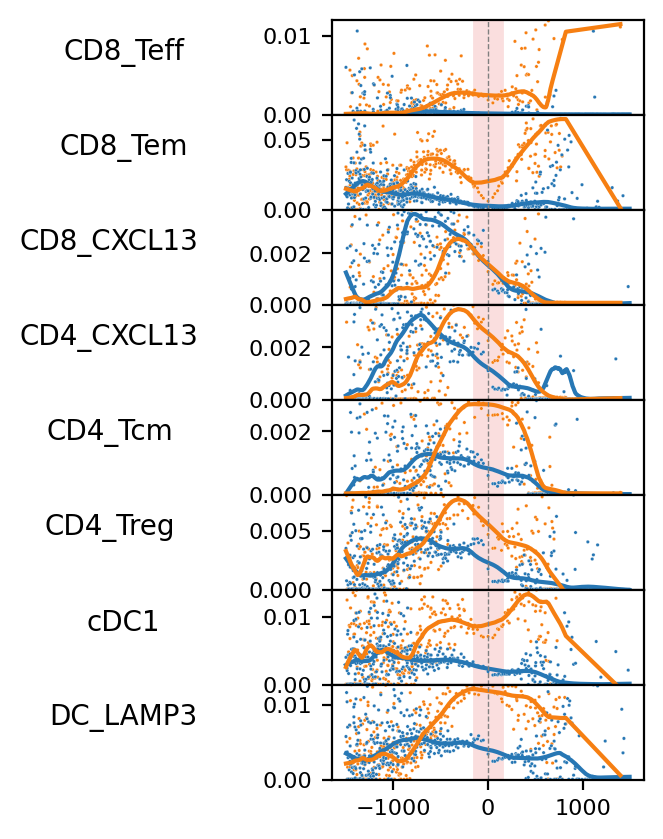

In [16]:
celltypes=['CD8_Teff','CD8_Tem','CD8_CXCL13','CD4_CXCL13','CD4_Tcm','CD4_Treg','cDC1','DC_LAMP3']
order=['pMMR', 'dMMR']
palette=["#2777B4","#F67F12"] #pMMR vs dMMR#
#order=['dNR', 'dR']
#palette=["g","m"] #dNR vs dR
distance = pd.concat([adata.obs.copy(), adata.obsm['anno_score_rctd']], axis=1)
distance = distance.sort_values('boundary_distance')

#add group info and subset to d/pMMR
distance['type'] = adata.obs['group2'][distance.index]
distance = distance[distance['type'].isin(order)]


merge = distance.groupby(['type','boundary_distance']).mean().reset_index()
merge = merge[~merge['B_act'].isna()]

merge['type'] = merge['type'].astype('str')

merge = merge[np.abs(merge['boundary_distance'])<30]
merge['boundary_distance'] = merge['boundary_distance'] * 50

sc.settings.set_figure_params(dpi=100, dpi_save=100,facecolor='white')

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig,axs=plt.subplots(nrows=len(celltypes),ncols=1,figsize=(2,5),sharex=True)

    for celltype,ax in zip(celltypes,axs):
        x,y = loess_smooth(data=merge,column=celltype,type=order[0])
        sns.lineplot(x=x,y=y,ax=ax,color=palette[0])
        
        
        x,y = loess_smooth(data=merge,column=celltype,type=order[1])
        sns.lineplot(x=x,y=y,ax=ax,color=palette[1])

        y = ax.get_ylim()
        
        sns.scatterplot(x='boundary_distance',y=celltype, data=merge,palette=palette,
            hue="type",hue_order=order,
            s=1.5,
            ax=ax)
        
        if y[0]<0:
            ax.set_ylim(0, y[1])
        else:
            ax.set_ylim(y[0], y[1])
        ax.axvspan(-150, 150, color='#fadede', zorder=0)
        ax.set_ylabel(ylabel=celltype,rotation=0,labelpad=50,fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.grid(visible=False)
        ax.axvline(x=0,color='grey',linestyle='--',lw='0.5')
        ax.get_legend().remove()
        ax.set_xlabel('')
        #ax.set_yscale('log')

    #ax.set_ylim(y[0]*0.6, y[1]*0.3)
    fig.subplots_adjust(hspace=0)
    
    fig.savefig('./fig2f_'+order[0]+'_vs_'+order[1]+'_rctd_distance.pdf',dpi=600,bbox_inches = 'tight')

### Fig. 2i immune_cell_rctd_different_groups

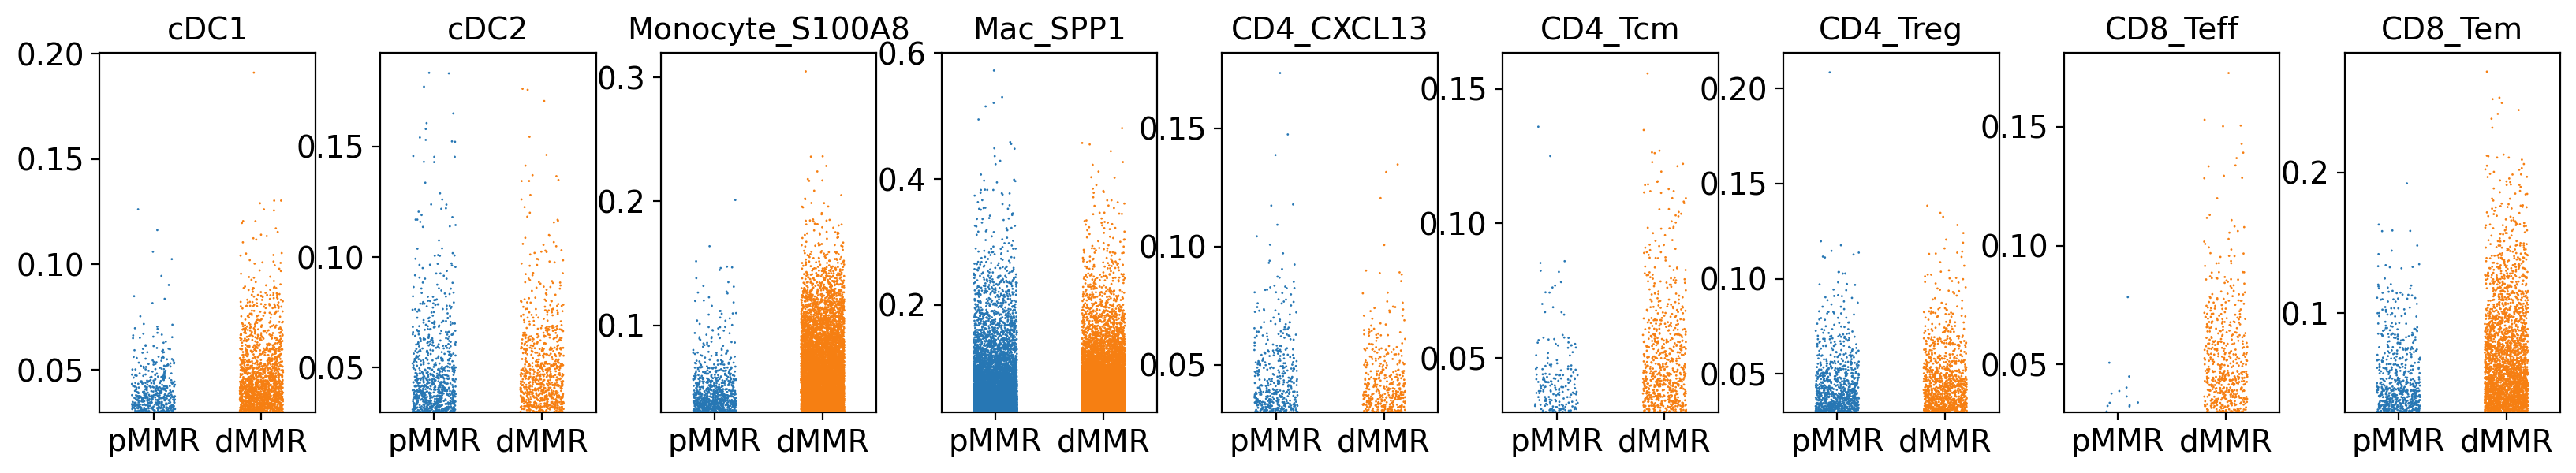

In [17]:
boundary_distance=[-3,3]
rctd_anno = pd.concat([adata.obs.copy(), adata.obsm['anno_score_rctd']], axis=1)
celltypes = ['cDC1', 'cDC2', 'Monocyte_S100A8', 'Mac_SPP1', 'CD4_CXCL13', 'CD4_Tcm', 'CD4_Treg', 'CD8_Teff', 'CD8_Tem']
order=['pMMR','dMMR']
palette=["#2777B4","#F67F12"]
cluster = rctd_anno[(rctd_anno['boundary_distance']>=boundary_distance[0]) & (rctd_anno['boundary_distance']<=boundary_distance[1])]
cluster = cluster[cluster['group2'].isin(order)]
cluster['group2'] = cluster['group2'].astype(str)

matplotlib.rcParams['figure.figsize'] = (20, 3)
fig, axs = plt.subplots(1, len(celltypes))
plt.subplots_adjust(wspace=0.3)
for celltype, ax in zip(celltypes, axs):
    dat = cluster[['group2',celltype]]
    sns.stripplot(data=dat,y=celltype,x='group2', hue='group2',size=1,jitter=0.2,
                       order=order,hue_order=order,palette=palette, ax=ax)
    ax.set_ylim(0.03, )
    # sns.boxplot(data=dat,y=celltype,x='group2', hue='group2',fliersize=0,order=order,
    #                   saturation=0.7,palette=palette, ax=ax, legend=False)
    ax.grid(False)
    ax.set_title(celltype)
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.savefig('./fig_2i_boundary_neighbor_'+order[0]+'_vs_'+order[1]+'.png',dpi=600,bbox_inches = 'tight')

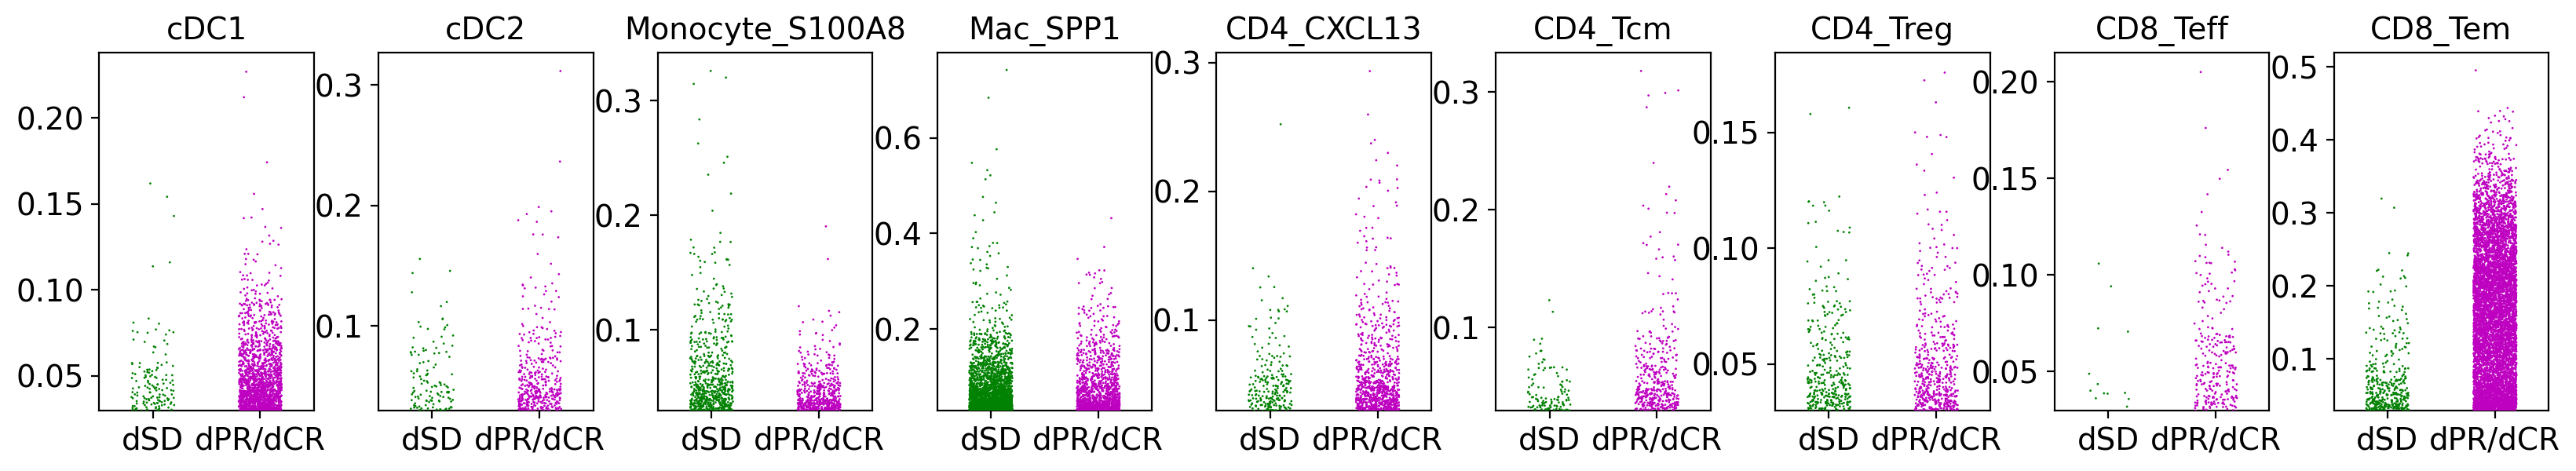

In [18]:
boundary_distance=[-3,3]
rctd_anno = pd.concat([adata.obs.copy(), adata.obsm['anno_score_rctd']], axis=1)
celltypes = ['cDC1', 'cDC2', 'Monocyte_S100A8', 'Mac_SPP1', 'CD4_CXCL13', 'CD4_Tcm', 'CD4_Treg', 'CD8_Teff', 'CD8_Tem']
order=['dSD','dPR/dCR']
palette=["#028203", "#be01c0"]
cluster = rctd_anno[(rctd_anno['boundary_distance']>=boundary_distance[0]) & (rctd_anno['boundary_distance']<=boundary_distance[1])]
cluster = cluster[cluster['group2'].isin(order)]
cluster['group2'] = cluster['group2'].astype(str)

matplotlib.rcParams['figure.figsize'] = (20, 3)
fig, axs = plt.subplots(1, len(celltypes))
plt.subplots_adjust(wspace=0.3)
for celltype, ax in zip(celltypes, axs):
    dat = cluster[['group2',celltype]]
    sns.stripplot(data=dat,y=celltype,x='group2', hue='group2',size=1,jitter=0.2,
                       order=order,hue_order=order,palette=palette, ax=ax)
    ax.set_ylim(0.03, )
    # sns.boxplot(data=dat,y=celltype,x='group2', hue='group2',fliersize=0,order=order,
    #                   saturation=0.7,palette=palette, ax=ax, legend=False)
    ax.grid(False)
    ax.set_title(celltype)
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.savefig('./fig_2i_boundary_neighbor_'+order[0]+'_vs_'+order[1].replace('/','_')+'.png',dpi=600,bbox_inches = 'tight')

###  Fig. 4h CAF_CXCL14_CAF_CXCL8_boundary_ratio

/tmp/ipykernel_59969/2665033756.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  'Mast','Endo','id','group2']].groupby('id').mean()


TtestResult(statistic=-3.065565658311527, pvalue=0.015451519407811911, df=8.0)
TtestResult(statistic=-0.0944563106783783, pvalue=0.9307019750060546, df=3.0)


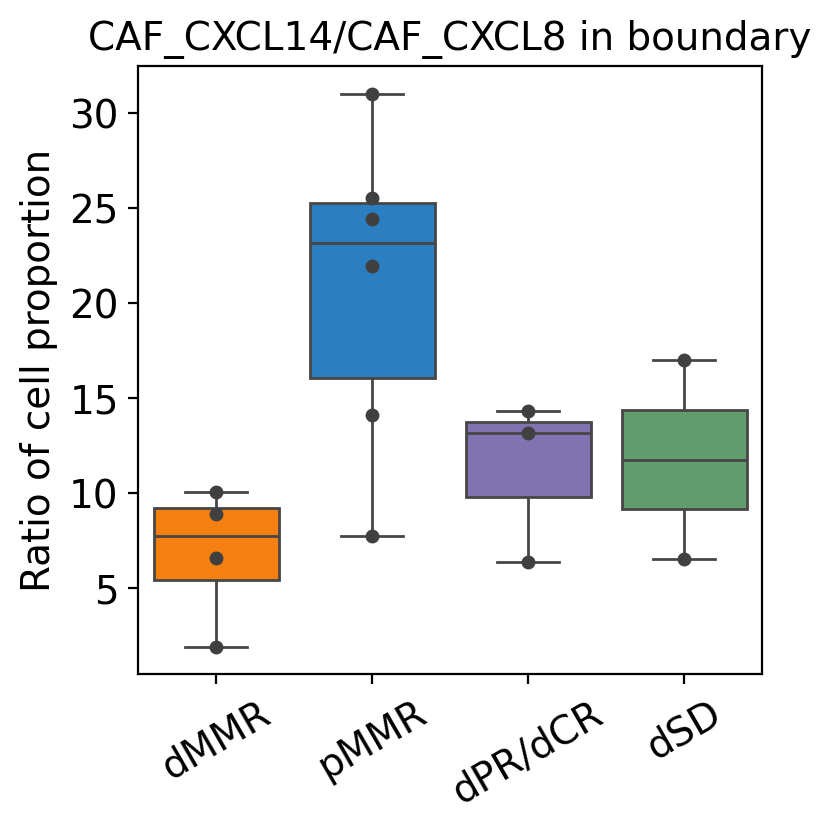

In [19]:
at_bound = rctd_anno[rctd_anno['boundary_distance']==0]
df=at_bound[['CD8_Teff','CD8_Cyto','CD8_CXCL13','CD8_HSP','CD8_Tem','CD4_CXCL13','CD4_Tcm','CD4_Treg','CD4_act','NK_gdT',
                  'B_act','B_naive','Plasma_IgM','Plasma_IgG',
                  'CAF_CXCL14','CAF_KCNN3','Fibro_NOTCH3','Fibro_MYH11','CAF_ADAMDEC1','CAF_PI16','Fibro_GPM6B','CAF_CXCL8',
                  'cDC1','cDC2','pDC','Mac_M1','Mac_M2','Mac_SPP1','Monocyte_S100A8','DC_LAMP3',
                  'Mast','Endo','id','group2']].groupby('id').mean()
df['ratio']=df['CAF_CXCL14']/df['CAF_CXCL8']
df['group2']='x'
df['id']=df.index
df.loc[df['id']=='CRCP67_T'  ,'group2']= 'pMMR' 
df.loc[df['id']=='CRCP59_T_2','group2']= 'pMMR' 
df.loc[df['id']=='CRCP56_T'  ,'group2']= 'dMMR' 
df.loc[df['id']=='CRCP55_T'  ,'group2']= 'pMMR' 
df.loc[df['id']=='CRCP95_T'  ,'group2']= 'dSD' 
df.loc[df['id']=='CRCP59_T'  ,'group2']= 'pMMR' 
df.loc[df['id']=='CRCP50_T'  ,'group2']= 'pMMR' 
df.loc[df['id']=='CRCP104_T','group2']= 'dSD' 
df.loc[df['id']=='CRCP112_T' ,'group2']= 'dPR/dCR' 
df.loc[df['id']=='CRCP107_T' ,'group2']= 'dMMR' 
df.loc[df['id']=='CRCP71_T'  ,'group2']= 'pMMR' 
df.loc[df['id']=='CRCP24_T'  ,'group2']= 'dPR/dCR' 
df.loc[df['id']=='CRCP25_T'  ,'group2']= 'dPR/dCR' 
df.loc[df['id']=='CRCP99_T'  ,'group2']= 'dMMR' 
df.loc[df['id']=='CRCP61_T'  ,'group2']= 'dPR/dCR' 
df.loc[df['id']=='CRCP100_T' ,'group2']= 'dMMR' 
df = df.drop('CRCP24_T')
order=['dMMR','pMMR','dPR/dCR','dSD']
x='group2'
y='ratio'
my_pal = {"dMMR": "#f67f11", "pMMR": "#2b7ebf", "dPR/dCR":"#8172b2", "dSD":'#609e6e'}
with plt.rc_context({'figure.figsize': [4, 4]}):
    plt.grid(visible=None) #隐藏网格线
    ax = sns.boxplot(data=df,x=x,y=y,hue='group2', 
                     dodge=False,order=order,palette=my_pal,saturation=1)
    ax = sns.swarmplot(data=df,x=x, y=y, color=".25",order=order,)
    # add_stat_annotation(ax, data=df, x=x, y=y,test='t-test_welch',order=order,
    #             box_pairs=[('dMMR', 'pMMR'), 
    #                        ('dPR/dCR','dSD')])
    ax.set(ylabel='Ratio of cell proportion', xlabel='')
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    # add_stat_annotation(ax, data=df, x="type", y='epithelia', order=order,
    #                 box_pairs=[('pMMR', 'dMMR')],
    #                 test='t-test_ind', text_format='star', loc='outside', verbose=2)
    plt.xticks(rotation=30)
    ax.set_title('CAF_CXCL14/CAF_CXCL8 in boundary')
plt.savefig('./fig4h_CAF_CXCL14_CAF_CXCL8_boundary_ratio.pdf',bbox_inches = 'tight')
print(stats.ttest_ind(df[df['group2']=='dMMR']['ratio'], df[df['group2']=='pMMR']['ratio'], nan_policy='omit'))
print(stats.ttest_ind(df[df['group2']=='dPR/dCR']['ratio'], df[df['group2']=='dSD']['ratio'], nan_policy='omit'))

###  Fig 5c stereo-seq boundary CAF_CXCL14 RCTD frequency and Extracellular Matrix Organization score

TtestResult(statistic=-25.476089506845387, pvalue=5.456515955081121e-132, df=3678.0)


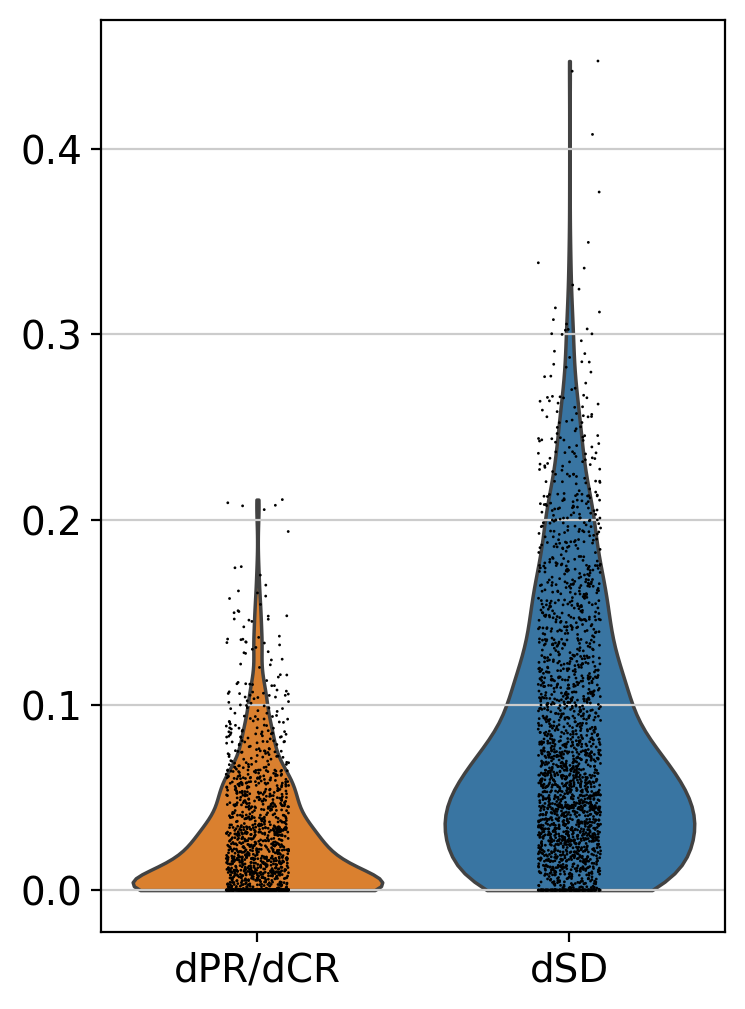

In [20]:
at_bound = rctd_anno[rctd_anno['boundary_distance']==0]
at_bound_dPR_dCR = at_bound[at_bound['response'].isin(['dPR', 'dCR'])]
at_bound_dSD = at_bound[at_bound['response'].isin(['dSD'])]

matplotlib.rcParams['figure.figsize'] = (4, 6)
ax = sns.violinplot({"dPR/dCR":at_bound_dPR_dCR['CAF_CXCL14'], "dSD":at_bound_dSD['CAF_CXCL14']},palette=["#F67F12", "#2777B4"], inner=None, cut=0)
sns.stripplot({"dPR/dCR":at_bound_dPR_dCR['CAF_CXCL14'], "dSD":at_bound_dSD['CAF_CXCL14']},palette=['black'] * 2, jitter=True, size=1)
plt.savefig('./fig_5c_boundary_CAF_CXCL14_dSD_vs_dPR_dCR.pdf',bbox_inches = 'tight')
print(stats.ttest_ind(at_bound_dPR_dCR['CAF_CXCL14'], at_bound_dSD['CAF_CXCL14']))

/tmp/ipykernel_59969/545682780.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  boundary_adata.obs['response2'] = boundary_adata.obs['id'].map(response2)


computing score 'EMO_gene_score'
       'ADAMTS10', 'ADAMTS17', 'ADAMTS16', 'ADAMTS15', 'ADAMTS14', 'ADAMTS19',
       'ADAMTS18', 'ADAM10', 'ADAM15', 'ADAMTS5', 'ADAMTS6', 'ADAMTS3',
       'ADAMTS4', 'ADAMTS1', 'ADAMTS2', 'ADAMTSL4', 'ADAMTS9', 'ADAMTS7',
       'ADAMTS8'],
      dtype='object')
    finished: added
    'EMO_gene_score', score of gene set (adata.obs).
    1195 total control genes are used. (0:00:01)


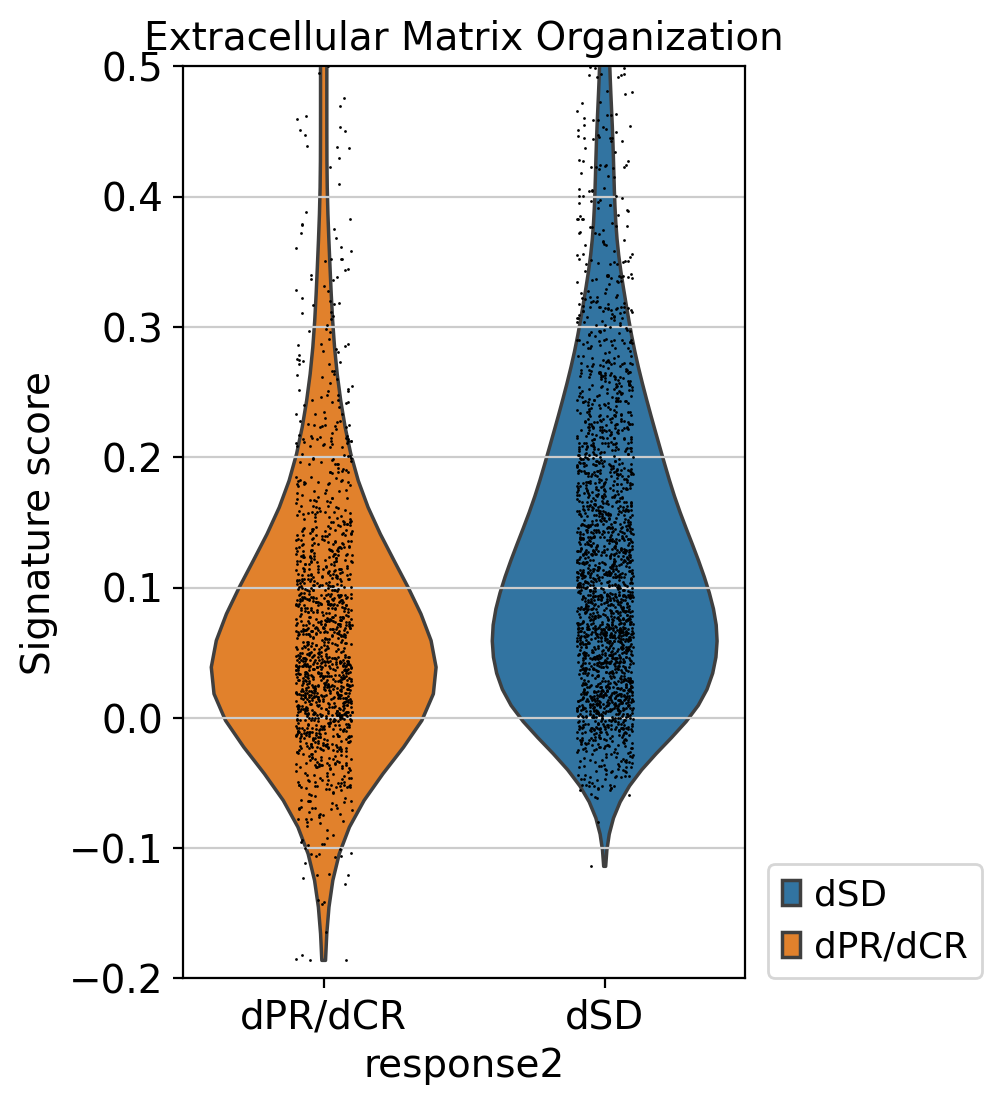

In [21]:
boundary_adata=adata[adata.obs["level1"].isin(["boundary"])]
boundary_adata
response2 = {
    'CRCP24_T': 'dPR/dCR',
    'CRCP25_T': 'dPR/dCR',
    'CRCP61_T': 'dPR/dCR',
    'CRCP95_T': 'dSD',
    'CRCP104_T': 'dSD',
    'CRCP112_T': 'dPR/dCR',
}
boundary_adata.obs['response2'] = boundary_adata.obs['id'].map(response2)
boundary_adata.obs["response2"]=pd.Categorical(boundary_adata.obs["response2"],categories=['dSD','dPR/dCR'])

##获取Extracellular Matrix Organization的gene列表
with open('/storeData/USER/data/02.Bioinformatics_for_STOmics/01.user/xiehongqing/analysis_work/work_ST_DGE_and_Enrichment/software/Gene_set_enrichment_analysis/GSEADB/GO_Biological_Process_2023.gmt', 'r') as file:
    for line in file:
        parts = line.strip().split('\t')
        pathway_name = parts[0]
        if pathway_name == 'Extracellular Matrix Organization (GO:0030198)': 
            genes = parts[2:] 

sc.tl.score_genes(boundary_adata,genes, score_name="EMO_gene_score")
ax=sc.pl.violin(boundary_adata,"EMO_gene_score",groupby="response2",ylabel='Signature score',order=['dPR/dCR','dSD'],show=False)
ax.set_ylim(-0.2,0.5)
ax.set_title('Extracellular Matrix Organization')
ax.legend(loc=(1.04,0))

### Fig S6.ab chemokine expressions in boundary of different groups¶

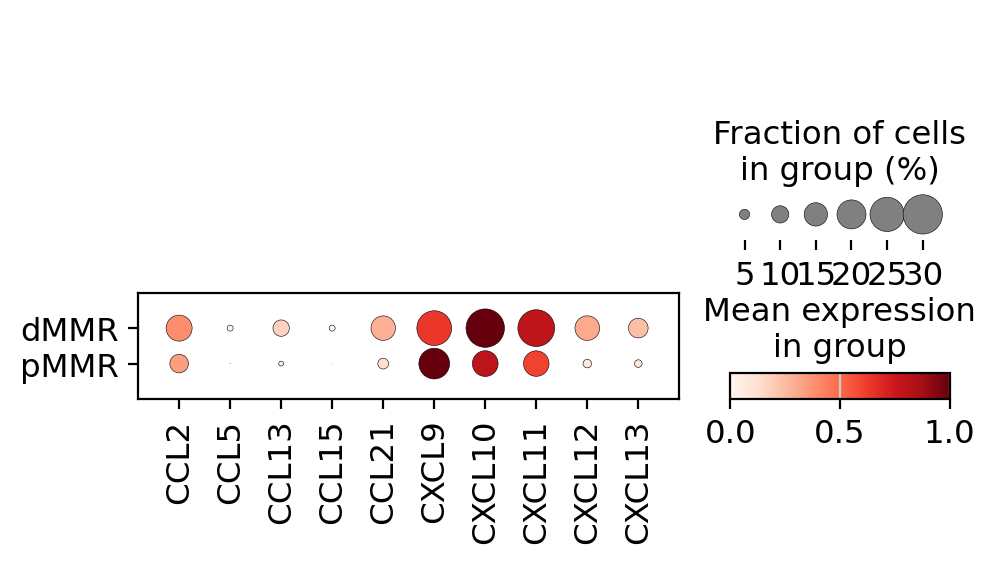

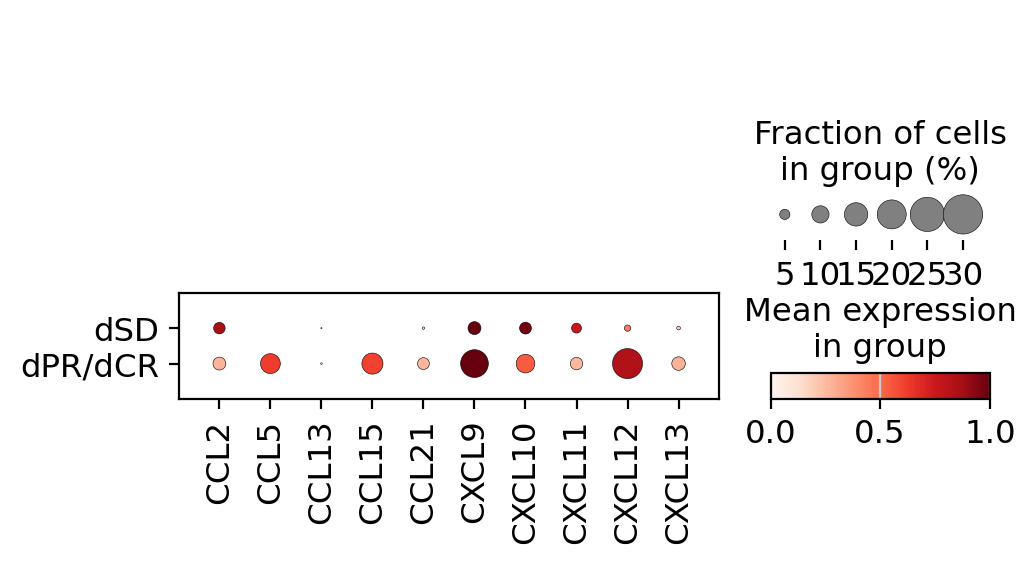

In [22]:
sc.pl.dotplot(boundary_adata[boundary_adata.obs["group2"].isin(["pMMR","dMMR"])], ["CCL2","CCL5","CCL13","CCL15", "CCL21","CXCL9","CXCL10","CXCL11","CXCL12","CXCL13"],groupby="group2",swap_axes=False,show=True,standard_scale='group')
sc.pl.dotplot(boundary_adata, ["CCL2","CCL5","CCL13","CCL15", "CCL21","CXCL9","CXCL10","CXCL11","CXCL12","CXCL13"],groupby="response2",swap_axes=False,show=True,standard_scale='group')